In [31]:
from scipy.integrate import quad
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from math import exp
import scipy as sc
import pandas as pd

## **Problème 2** : Calibrations d'hyper-paramètres d'une regression de processus gaussien par maximum de vraissemblance.
# BLABLABLA RESUMER LE PROBLEME ICI


In [39]:
def cov_k(x0, x1, lambd = 1) :
    return (1+ ((abs(x0 - x1))/lambd) + (((abs(x0-x1))**2)/(3*(lambd**2)))) * exp(-((abs(x0-x1))/lambd))

def compute_cov_sigma(x, lambd = 1) :
    return np.array([[cov_k(xi, xj, lambd) for xj in x] for xi in x])


def compute_sigma(x, lambd = 1) :
    sigma = np.zeros((x.shape[0], x.shape[0]))
    for i, x0 in enumerate(x) :
        for j, x1 in enumerate(x) :
            sigma[i, j] = abs(cov_k(x0, x1, lambd=lambd))
    
    return sigma

### 1. Simulation de plusieurs réalisations d'un processus Gaussien de moyenne nulle et de fonction de covariance $k_1$
####    1.a. Moyenne et matrice de covariance du vecteur aléatoire $m + L^tG$
- Prenons $N$ valeurs équi-distribuées avec $x_i \in [0,1]$ tels que $x_1 < \dots < x_N$.
- Fixons $\lambda = 1$ et calculons $\Sigma$, la matrice de covariance 

In [46]:
N = 1500

_out = True
if N > 50 :
    _out = False

lambd = 0.1

#To get N numbers evenly spread between 0 and 1, linspace() from numpy
xi = np.linspace(0, 1, N)
sigma = compute_cov_sigma(xi, lambd=lambd)

if(_out) :
    print("xi : ", xi.round(2))
    print("Sigma :")
    print(sigma.round(3))
else:
    print("xi and Sigma computed !")

xi and Sigma computed !


- Calculons $L$, la décomposition de Cholesky de $\Sigma$
- Prenons $G$, un vecteur de taille $N$ dont les valeurs sont des tirages aléatoires indépendants d'une loi Gausienne centrée réduite
- Notons $m = (m(x_1), \dots, m(x_N))$ (que l'on considère non nul uniquement pour cette question)

In [47]:
L = la.cholesky(sigma)

G = np.random.normal(0, 1, N)

m = xi

if _out :
    print("L :\n", L.round(2))
    print("G :\n", G.round(2))
    print("m :\n", m.round(2))
else :
    print("L, G and m computed !")

L, G and m computed !


Avec ces élements, calculons le vecteur aléatoire *$m + L^tG$*, que nous noterons $v$ pour cette question.

Nous allons nous intéresser à la moyenne et la matrice de covariance de ce vecteur.

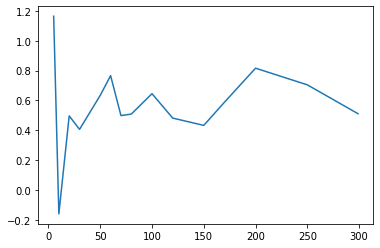

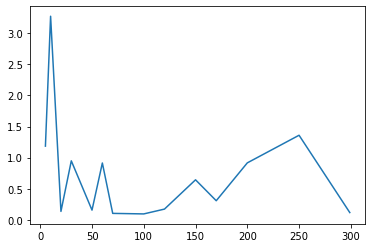

In [28]:
v = m + (L.T @ G)

ns = [5, 10, 20, 30, 50, 60, 70, 80, 100, 120, 150, 170, 200, 250, 299]
means = []
covs  = []

for _n in ns :
    _xi = np.linspace(0, 1, _n)
    _sigma = compute_cov_sigma(_xi)
    _L = la.cholesky(_sigma)
    _G = np.random.normal(0, 1, _n)
    _m = _xi
    _v = _m + (_L.T @ _G)
    
    means.append(np.mean(_v))
    covs.append(np.cov(_v))
    

plt.figure("Means")
plt.plot(ns, means)

plt.figure("Covs")
plt.plot(ns, covs)


# CONCLUSION DU a) ICI

#### 1.b. Simulation d'un vecteur gaussien
Nous allons simuler $g =  (g_1, \dots, g_N)$ une réalisation de $G$ et calculer le vecteur $(z_1, \dots, z_N) = L^tg$.

#### 1.c. Etude numérique de la simulation 
Nous allons ensuite tracer le graphe $(x_i, z_i)_{i=1, \dots, N}$ qui représente une réalisation du processus Gaussien $Z$ pour une valeur de paramètre $\lambda=1$

#### 1.d. Réitération de la simulation
Enfin, nous allons réaliser (b) plusieurs fois, et représenter sur le même graphe les différentes réalisation de $Z$

In [111]:
#1.b
g = np.random.normal(0, 1, N)

z = L.T @ g

if _out :
    print("z :\n", z)
else :
    print("g and z computed !")
    
#1.c


#1.d

z :
 [ 0.41507802 -0.95173679 -0.37614248 -0.19461043 -0.14071625 -0.10410847
 -0.07170929 -0.04017375 -0.01851391 -0.00502732]


## BLABLA ON CONSTATE SUR b,c,d

#### 1.e. Changement du paramètre $\lambda$
Nous allons maintenant réitérer l'expérience ci-dessus (questions(a) à (d)) en changeant la valeur du paramètre $\lambda$, initialement fixé à 1.

On constate qu'en changeant le paramètre lambda, ...


### 2. Estimation du paramètre $\lambda$ par maximum de vraissemblance